Upload image file for classification to collab and unzip

In [ ]:

!unzip /content/fullstackquantumout.zip -d /content/

Archive:  /content/fullstackquantumout.zip
  inflating: /content/fullstackquantumout/1.png  
 extracting: /content/fullstackquantumout/10.png  
 extracting: /content/fullstackquantumout/100.png  
 extracting: /content/fullstackquantumout/101.png  
 extracting: /content/fullstackquantumout/102.png  
 extracting: /content/fullstackquantumout/103.png  
 extracting: /content/fullstackquantumout/104.png  
 extracting: /content/fullstackquantumout/105.png  
 extracting: /content/fullstackquantumout/106.png  
  inflating: /content/fullstackquantumout/107.png  
 extracting: /content/fullstackquantumout/108.png  
 extracting: /content/fullstackquantumout/109.png  
  inflating: /content/fullstackquantumout/11.png  
 extracting: /content/fullstackquantumout/110.png  
 extracting: /content/fullstackquantumout/111.png  
 extracting: /content/fullstackquantumout/112.png  
 extracting: /content/fullstackquantumout/113.png  
  inflating: /content/fullstackquantumout/114.png  
 extracting: /content/ful

Download the original dataset for classification label

Upload kaggle.json for API key to download

In [3]:
from google.colab import files
files.upload()
#2. Series of commands to set-up for download

!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory

#3. giving rw access (if 401-nathorized)

!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 67 Jan 28 01:35 kaggle.json
/content


if using histopathologic cancer dataset

In [4]:
#!kaggle datasets download -d competitions/histopathologic-cancer-detection
!mkdir -p /content/histopathologic-cancer
!kaggle competitions download -c histopathologic-cancer-detection
!unzip -qq /content/histopathologic-cancer-detection.zip -d /content/histopathologic-cancer

100% 6.31G/6.31G [05:12<00:00, 24.0MB/s]
100% 6.31G/6.31G [05:13<00:00, 21.6MB/s]


if using blood cancer dataset

In [ ]:
!mkdir -p /content/blood-cancer
!kaggle datasets download -d andrewmvd/leukemia-classification
!unzip -qq /content/leukemia-classification.zip -d /content/blood-cancer

if using skin cancer dataset

In [ ]:
!mkdir -p /content/skin-cancer
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -qq /content/skin-cancer-mnist-ham10000.zip -d /content/skin-cancer

# Classification using CNN

import required package

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
base_dir = '/content'
print(os.listdir(base_dir))

# Matplotlib for visualization
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# OpenCV Image Library
import cv2

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

# Import useful sklearn functions
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image

['.config', 'kaggle.json', 'histopathologic-cancer', 'histopathologic-cancer-detection.zip', 'sample_data']


In [ ]:
print(torchvision.__version__)

0.15.2+cu118


In [5]:
full_train_df = pd.read_csv("/content/histopathologic-cancer/train_labels.csv")
full_train_pruned = full_train_df.iloc[1:900]
full_train_pruned.id = full_train_pruned.index
full_train_pruned.head()

<ipython-input-5-00824278e79a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_train_pruned.id = full_train_pruned.index


,id,label
1,1,1
2,2,0
3,3,0
4,4,0
5,5,0


In [7]:
print("Train Size: {}".format(len(os.listdir('/content/histopathologic-cancer/train/'))))
print("Test Size: {}".format(len(os.listdir('/content/histopathologic-cancer/test/'))))

Train Size: 220025
Test Size: 57458


0    531
1    368
Name: label, dtype: int64


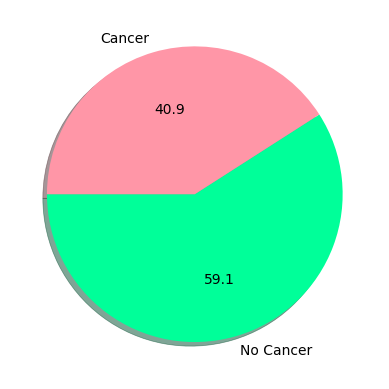

<Figure size 1600x1600 with 0 Axes>

In [8]:
labels_count = full_train_pruned.label.value_counts()
print(labels_count)

%matplotlib inline
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180,
        autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)
plt.figure(figsize=(16,16))
plt.show()

Visualizing the dataset

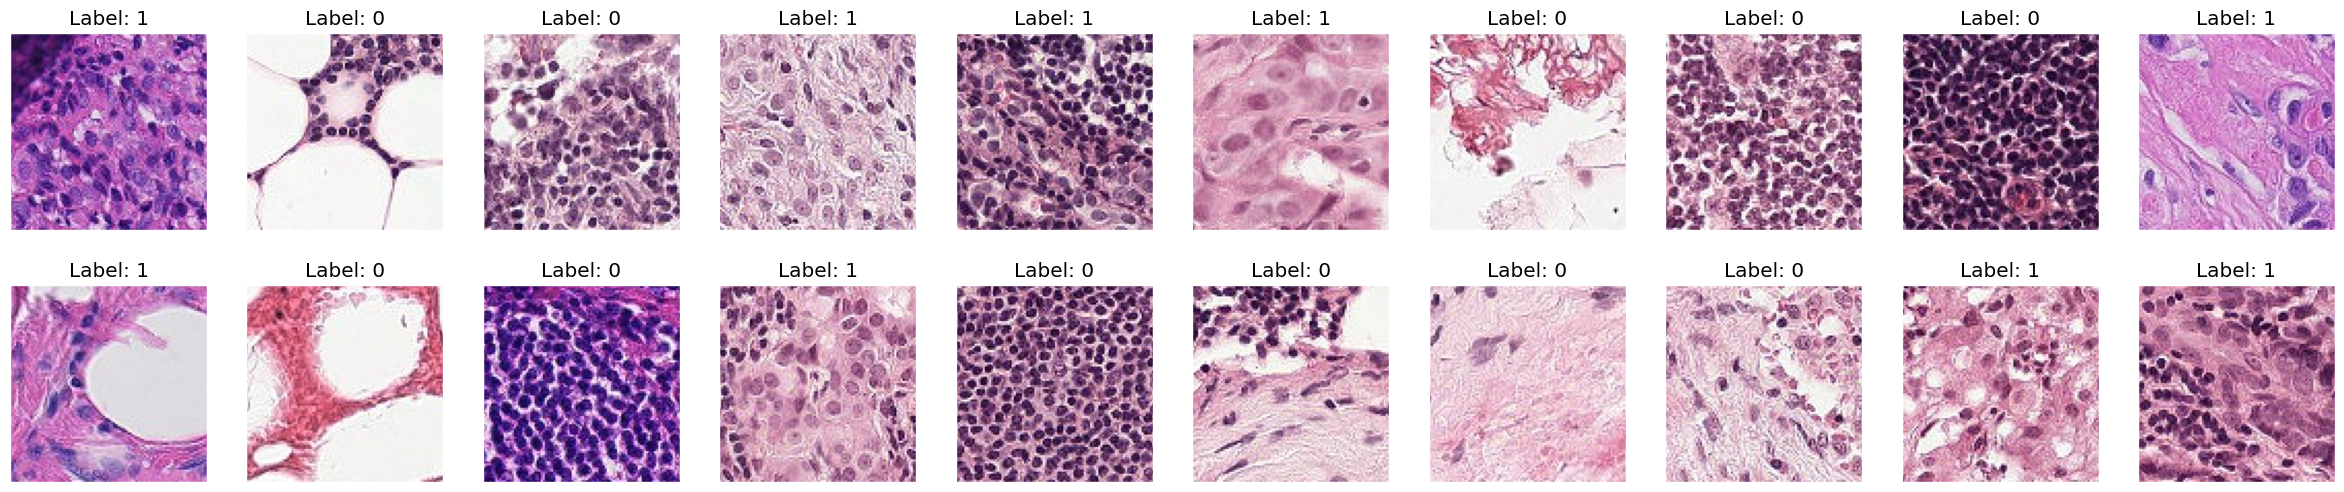

In [ ]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir("/content/hist_can/train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("/content/hist_can/train/" + img)
    plt.imshow(im)
    lab = full_train_df.loc[full_train_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

Sampling dataset for using in training

In [9]:
import torchvision.transforms.functional as fn
# Number of samples in each class
SAMPLE_SIZE = 400

# Data paths
train_path = '/content/histopathologic-cancer/train'
test_path = '/content/histopathologic-cancer/test'

# Use 80000 positive and negative examples
df_negatives = full_train_df[full_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = full_train_df[full_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up

train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

train_df.shape

(800, 2)

Preprocessing dataset

In [10]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, str(img_name)+'.png')
        image = cv2.imread(img_path)

        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [11]:
import torchvision.transforms.functional as fn
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32,32),interpolation=fn.InterpolationMode.NEAREST),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    # We the get the following mean and std for the channels of all the images
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

])

train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

In [22]:
# Set Batch Size
batch_size = 128

# Percentage of training set to use as validation
valid_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

In [23]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32,32),interpolation=fn.InterpolationMode.NEAREST),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),


])

# creating test data
#sample_sub = pd.read_csv("/content/sample_submission.csv")
#test_data = CreateDataset(df_data=train, data_dir=test_path, transform=transforms_test)
test_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_test)

# prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [15]:
class CNN(nn.Module):
    def __init__(self):

        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=0),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))

        self.dropout2d = nn.Dropout2d()


        self.fc=nn.Sequential(
                nn.Linear(512*1*1,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, 1),
                nn.Sigmoid())

    def forward(self,x):
        """Method for Forward Prop"""
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        #print(x.shape)
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [16]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Training and Validation

In [17]:
# create a complete CNN
model = CNN()
print(model)

# Move model to GPU if available
if train_on_gpu: model.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [18]:
# Trainable Parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
2610369


define loss function

In [19]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [24]:
n_epochs = 20

valid_loss_min = np.Inf


train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []

for epoch in range(1, n_epochs+1):


    train_loss = 0.0
    valid_loss = 0.0


    model.train()
    for data, target in train_loader:

        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)

        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)
        #output = output.topk()
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # print training/validation statistics
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))

    ##################
    # Early Stopping #
    ##################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

TypeError: pic should be Tensor or ndarray. Got <class 'NoneType'>.

In [ ]:
torch.save(model.state_dict(),"fullsize.pth")

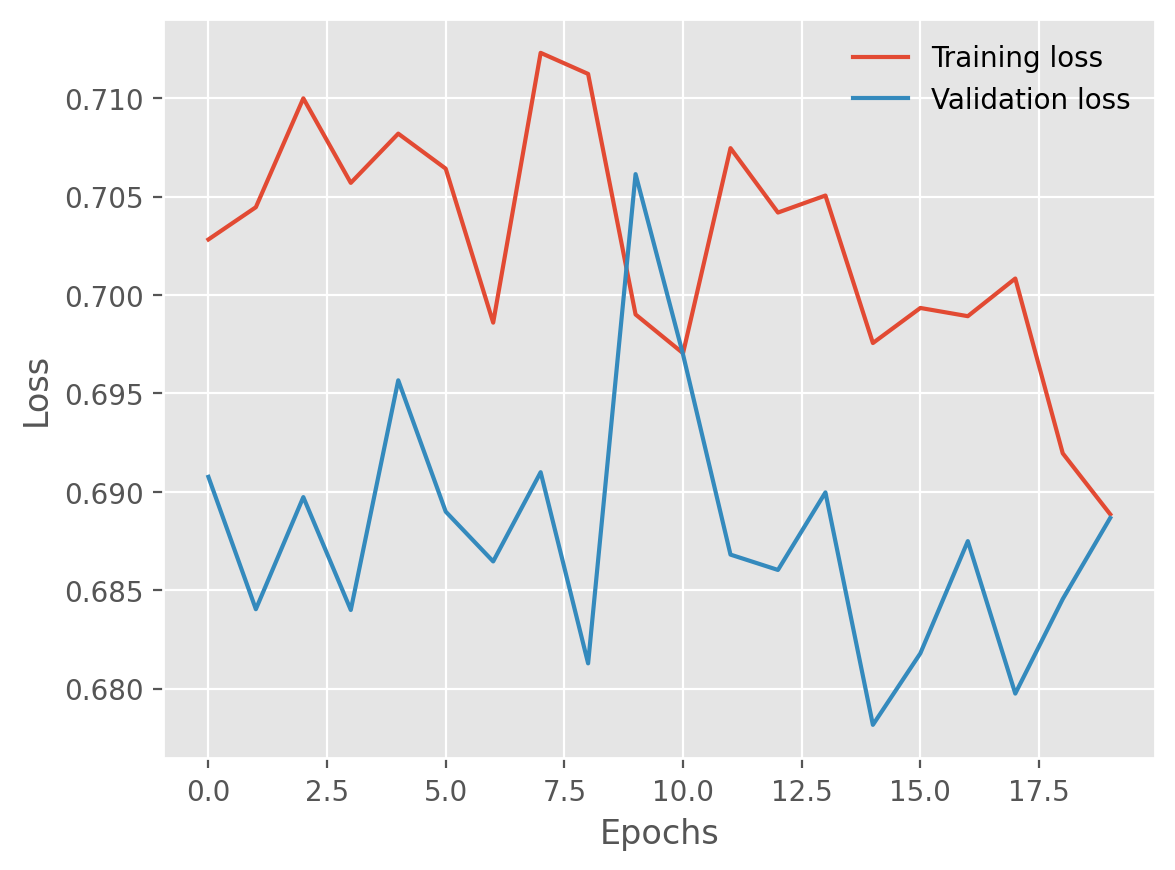

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

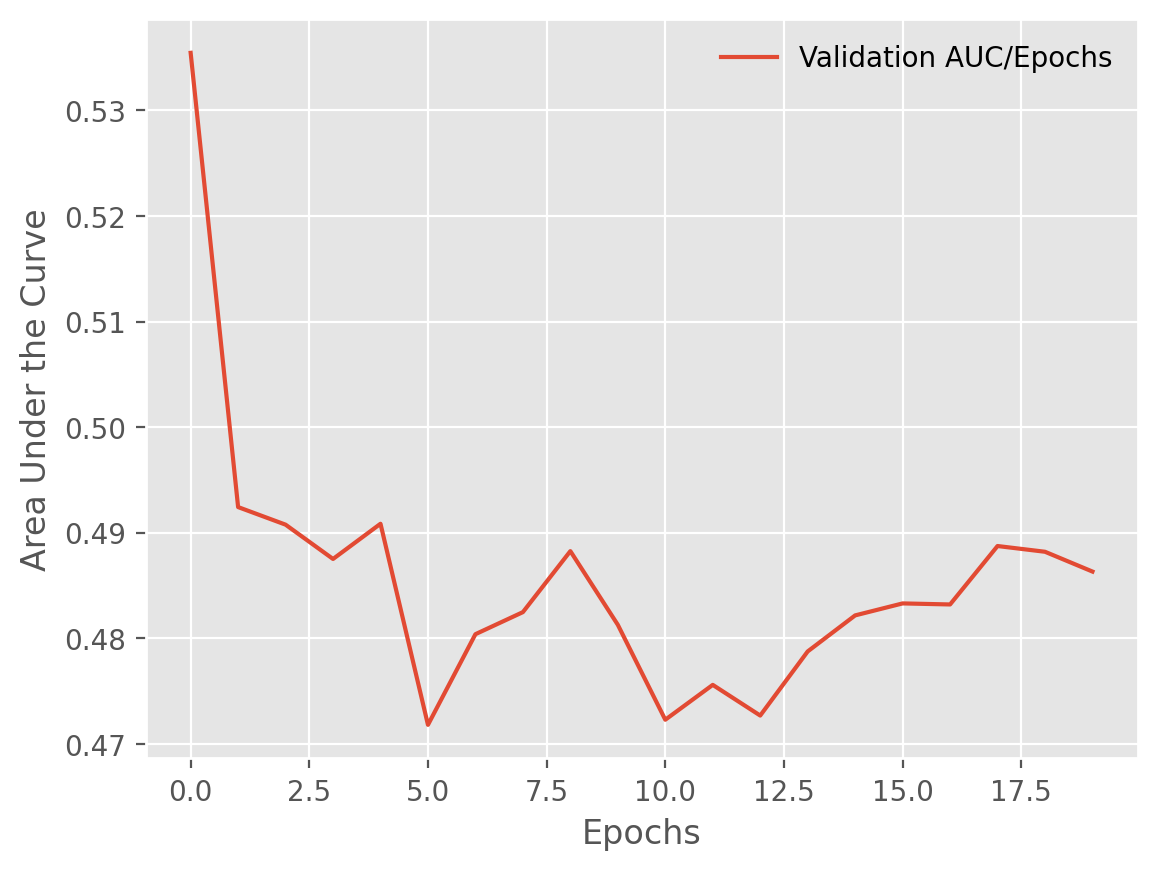

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(auc_epoch, label='Validation AUC/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Area Under the Curve")
plt.legend(frameon=False)

load saved model

In [ ]:
# Load Best parameters learned from training into our model to make predictions later
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

evaluation

In [ ]:
# Turn off gradients
model.eval()

preds = []
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        preds.append(i)

# Create Submission file
print(preds)

[array([0.38130295], dtype=float32), array([0.5115853], dtype=float32), array([0.5810132], dtype=float32), array([0.45506984], dtype=float32), array([0.42937744], dtype=float32), array([0.62686646], dtype=float32), array([0.42937744], dtype=float32), array([0.29200402], dtype=float32), array([0.51058656], dtype=float32), array([0.49328038], dtype=float32), array([0.44196907], dtype=float32), array([0.45132208], dtype=float32), array([0.4117803], dtype=float32), array([0.51058656], dtype=float32), array([0.48318902], dtype=float32), array([0.17616794], dtype=float32), array([0.51058656], dtype=float32), array([0.5219894], dtype=float32), array([0.3827693], dtype=float32), array([0.45132208], dtype=float32), array([0.5272757], dtype=float32), array([0.5810132], dtype=float32), array([0.48341313], dtype=float32), array([0.43157643], dtype=float32), array([0.6191358], dtype=float32), array([0.38307688], dtype=float32), array([0.3920861], dtype=float32), array([0.5037771], dtype=float32), a

In [ ]:
for i in range(len(sample_sub)):
    sample_sub.label[i] = np.float(sample_sub.label[i])

<ipython-input-131-470857900eec>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_sub.label[i] = np.float(sample_sub.label[i])


In [ ]:
sample_sub.to_csv('submission.csv', index=False)
sample_sub.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.003314
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.253405
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.00228
3,2c35657e312966e9294eac6841726ff3a748febf,0.02269
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.022528


# Classification using Quantum CNN

Install and Import the required package

In [26]:
!pip install qiskit
!pip install qiskit-machine-learning
!pip install pylatexenc
!pip install numpy
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.9/306.9 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512583 sha256=74e22aa23136b1bb0f0538c20c5a246f4e0f1550cb78e5d41

In [27]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
import tensorflow as tf
algorithm_globals.random_seed = 12345

<ipython-input-27-b4d29a465f65>:6: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA
<ipython-input-27-b4d29a465f65>:15: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 12345


/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


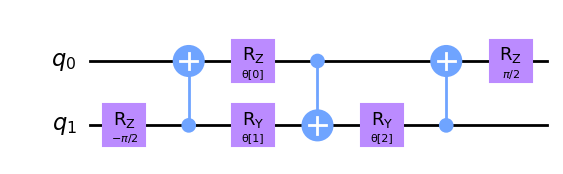

In [28]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

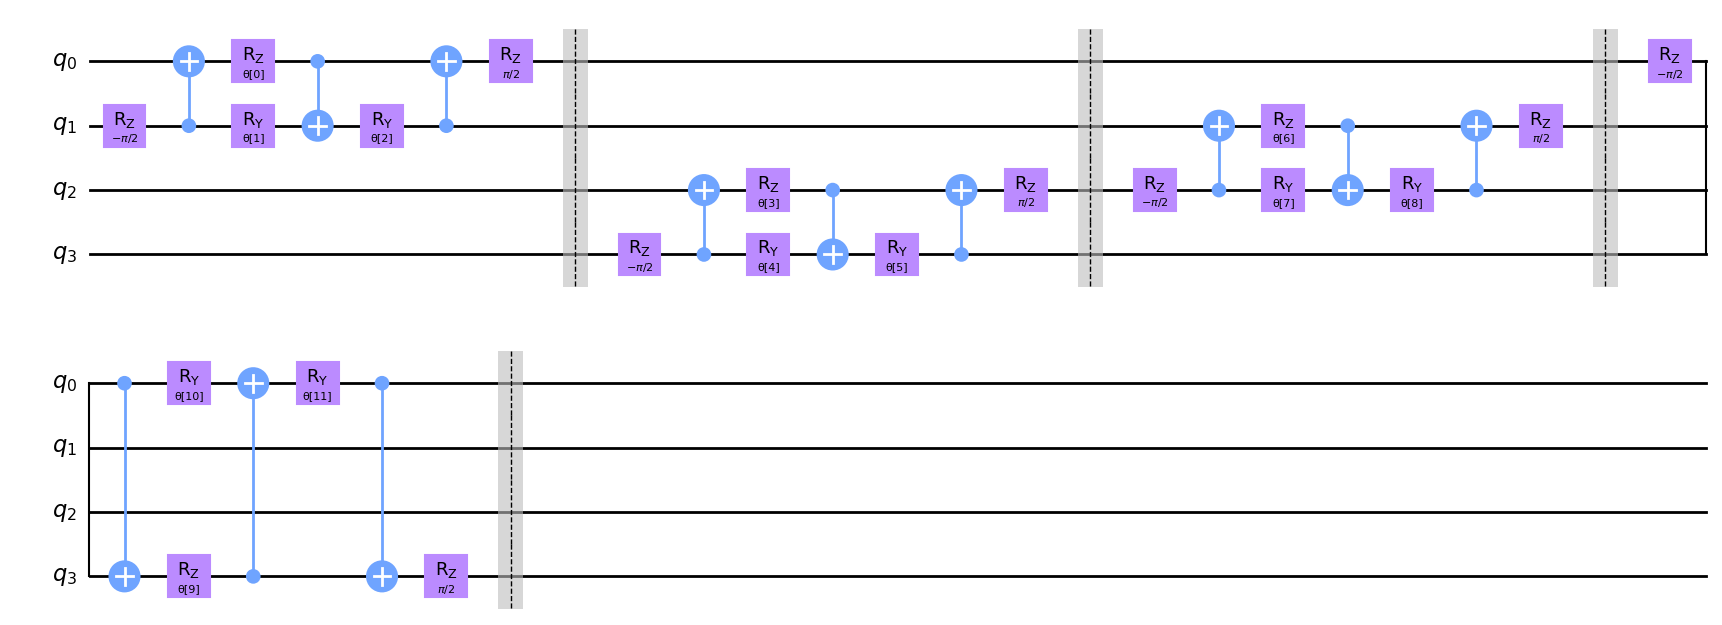

In [29]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

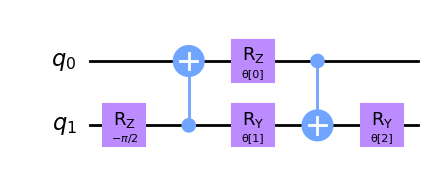

In [30]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

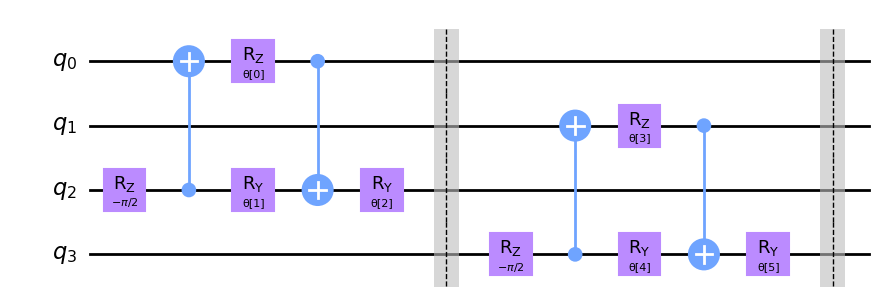

In [31]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

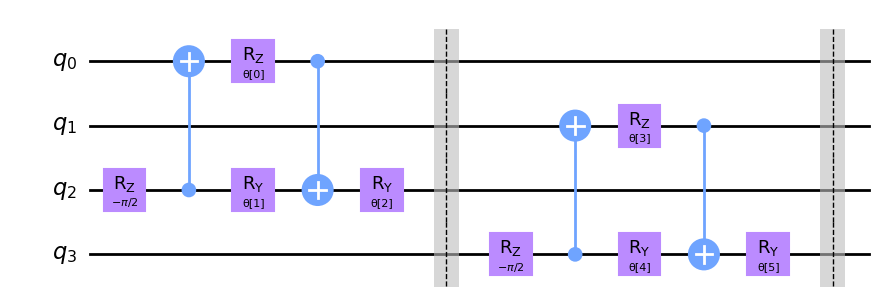

In [32]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [33]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

#Showing the length of the train and test sets
print("Number of images in the training set:", len(x_train))
print("Number of images in the test set:", len(x_test))

11490434/11490434 [==============================] - 2s 0us/step
Number of images in the training set: 60000
Number of images in the test set: 10000


In [34]:
def filter_01(x, y):
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    return x,y
x_train, y_train = filter_01(x_train, y_train) #Filter the train set
x_test, y_test = filter_01(x_test, y_test) #Filter the test set

#Showing the length of the train and test sets after filtering the data
print("Number of images in the training set:", len(x_train))
print("Number of images in the test set:", len(x_test))

Number of images in the training set: 12665
Number of images in the test set: 2115


In [35]:
x_train_small = tf.image.resize(x_train, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()
x_test_small = tf.image.resize(x_test, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()

In [36]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [37]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [38]:
initial_point = [1.930057091422052, 0.2829424508139703, 0.35555636265939633, 0.1750006532903061, 0.3002103666790018, 0.6641911912373437, 1.3310981300850042, 0.5022717197547227, 0.44912874128880675, 0.40236963192983266, 0.3459537084665159, 0.9786311288435154, 0.48716712269991697, -0.007081389738930712, 0.21570815199311827, 0.07334182375267477, 0.6907887498355103, 0.21771166428570735, 1.087665977608006, 1.2571463700739218, 1.0866597360102666, 2.126145551821481, 0.8914518096731741, 1.5053260036617715, 0.44798876926441555, 0.9498701675467225, 0.15490304396579338, 0.1338674031994701, -0.6938374500039391, 0.029396385425104116, -0.09785818314088227, -0.31198441382224246, 0.20004568516690807, 1.848494069662786, -0.028371899054628447, -0.15229494459622284, 0.7653870524298326, 0.6881492316484289, 0.6759011152318357, 1.6028387103546868, 0.47711915171800057, -0.26162053028790294, -0.12898443497061718, 0.5281303751714184, 0.4957555866394333, 1.6095784010055925, 0.5685823964468215, 1.2812276175594062, 0.3032325725579015, 1.4291081956286258, 0.7081163438891277, 1.8291375321912147, -0.11047287562207528, 0.2751308409529747, 0.2834764252747557, 0.29668607404725605, 0.008300790063532154, 0.6707732056265118, 0.5325267632509095, 0.7240676576317691, 0.08123934531343553, -0.0038536767244725153, -0.1001165849018211]
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

In [39]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")
5

NameError: name 'train_images' is not defined